A happy or sad dataset which contains 80 images, 40 happy and 40 sad. Create a convolutional neural network that trains to 100% accuracy on these images, which cancels training upon hitting training accuracy of >.999

In [1]:
import tensorflow as tf
import os
import zipfile

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip \
    -O /tmp/happy-or-sad.zip

--2020-07-31 14:07:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.02s   

2020-07-31 14:07:02 (141 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



In [3]:
local_zip = '/tmp/happy-or-sad.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/happy-or-sad')
zip_ref.close()

In [27]:
# Defining myCallback class
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') >= 0.999:
      print('Reached 100% accuracy so cancelling training!')
      self.model.stop_training = True
callback = myCallback()

In [6]:
# Directory with our training happy pictures
train_happy_dir = os.path.join('/tmp/happy-or-sad/happy')

# Directory with our training sad pictures
train_sad_dir = os.path.join('/tmp/happy-or-sad/sad')

In [8]:
train_happy_names = os.listdir(train_happy_dir)
print(train_happy_names[:10])

train_sad_names = os.listdir(train_sad_dir)
print(train_sad_names[:10])

['happy1-02.png', 'happy1-16.png', 'happy1-00.png', 'happy2-18.png', 'happy2-12.png', 'happy2-03.png', 'happy2-05.png', 'happy2-13.png', 'happy1-05.png', 'happy2-11.png']
['sad1-14.png', 'sad1-06.png', 'sad2-12.png', 'sad2-11.png', 'sad2-16.png', 'sad1-13.png', 'sad1-11.png', 'sad2-03.png', 'sad1-15.png', 'sad2-02.png']


In [9]:
print('total training happy images:', len(os.listdir(train_happy_dir)))
print('total training sad images:', len(os.listdir(train_sad_dir)))

total training happy images: 40
total training sad images: 40


In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

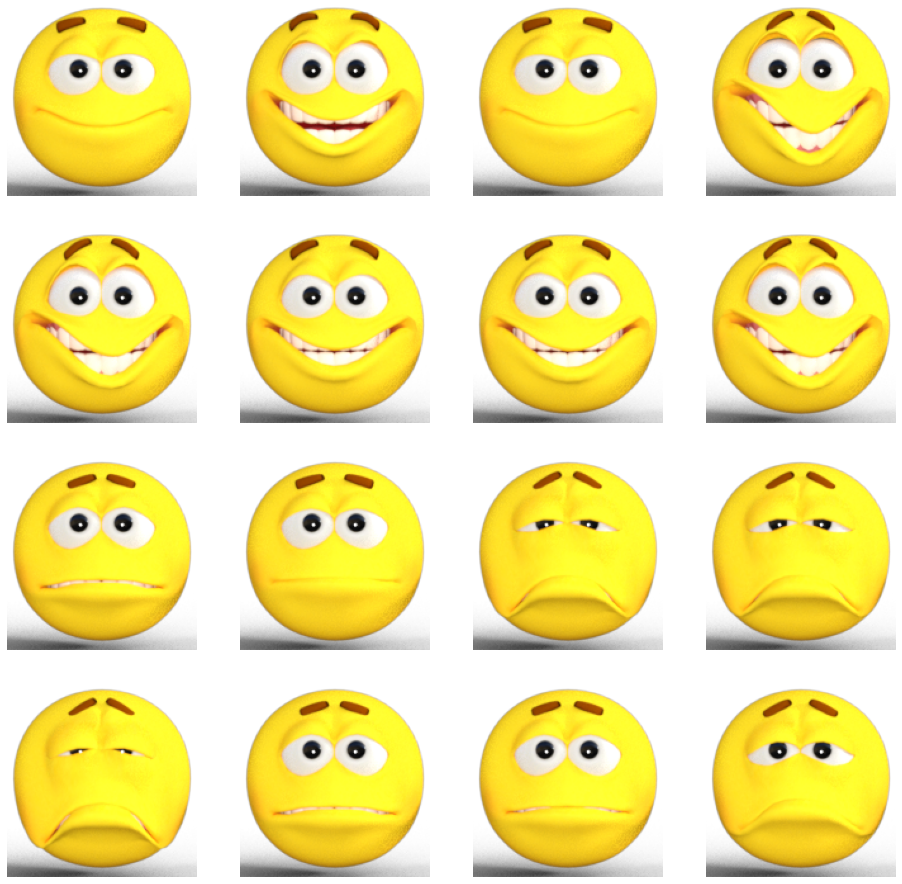

In [12]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_happy_pix = [os.path.join(train_happy_dir, fname) 
                for fname in train_happy_names[pic_index-8:pic_index]]
next_sad_pix = [os.path.join(train_sad_dir, fname) 
                for fname in train_sad_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_happy_pix+next_sad_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [23]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
# validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/happy-or-sad/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

"""# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
"""

Found 80 images belonging to 2 classes.


"# Flow training images in batches of 128 using train_datagen generator\nvalidation_generator = validation_datagen.flow_from_directory(\n        '/tmp/validation-horse-or-human/',  # This is the source directory for training images\n        target_size=(300, 300),  # All images will be resized to 300x300\n        batch_size=32,\n        # Since we use binary_crossentropy loss, we need binary labels\n        class_mode='binary')\n"

In [33]:
history = model.fit(
      train_generator,
      steps_per_epoch=1,  
      epochs=15,
      verbose = 1,
      callbacks = [callback])

Epoch 1/15
1/1 [==============================] - 0s 5ms/step - loss: 0.6658 - accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 2ms/step - loss: 0.4563 - accuracy: 0.9250
Epoch 3/15
1/1 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.7500
Epoch 4/15
1/1 [==============================] - 0s 2ms/step - loss: 0.5439 - accuracy: 0.7125
Epoch 5/15
1/1 [==============================] - 0s 2ms/step - loss: 0.6290 - accuracy: 0.6625
Epoch 6/15
1/1 [==============================] - 0s 2ms/step - loss: 0.4100 - accuracy: 0.8750
Epoch 7/15
1/1 [==============================] - 0s 2ms/step - loss: 0.2559 - accuracy: 1.0000
